# FOX Feature Importance and Model Tests

In this notebook I:

* Export the feature importance array from the best model
* Test the model on some "wild" data, i.e. not already coded
* Test the model on CNN data
* Examine some mis-classified sentences

In [1]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize  
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from math import sqrt

Here I'm recreating the best model found in the performance tuning.

In [2]:
fox_df = pd.read_excel('../data/interim/fox_ready_to_code.xlsx').drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).fillna(0)
len(fox_df)

10000

In [3]:
y = np.array(fox_df['isad'])
X = fox_df.drop(columns=['identifier', 'contributor', 'subjects', 'start_time', 'stop_time', 'runtime',
                        'isad']).dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

In [ ]:
nltk.download('stopwords')

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could',
                           '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many',
                           'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                           'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                           'line', 'even', 'also', 'may', 'take', 'come', 'hi', 'ha', 'le', 'u', 'wa', 'thi',
                           'to', 'one'])

In [5]:
def clean_sent(sentences):
    for sent in sentences:
        sent = str(sent)
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub("([\d,\,\./!#%&\'\":;>\?@\[\]`)(\+])+", "", sent) # remove digits and remove punctuation
        sent = re.sub("([-])+", " ", sent)
        yield(sent)  

In [6]:
corpus_train = list(clean_sent(X_train.sentence.values.tolist()))
corpus_test = list(clean_sent(X_test.sentence.values.tolist()))
corpus_train[:5]

['they dont want to',
 'and as i said ive put on as a lawyer expert witnesses',
 'bidens website has been updated with citations',
 'all that continues next',
 ' to build on what john said yes pomp circumstance and some politics which donald trump talked about on his trip']

In [7]:
#lemmatize before vectorizing

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), strip_accents='unicode', stop_words='english', 
                       min_df=2, max_df=0.3, ngram_range=(1,2))

In [ ]:
nltk.download('punkt')

In [ ]:
nltk.download('wordnet')

In [8]:
X_train_bow = vect.fit_transform(corpus_train)
X_test_bow = vect.transform(corpus_test)
X_train_bow_df = pd.DataFrame(X_train_bow.toarray())
X_train_bow_df.columns = vect.get_feature_names()
X_train_bow_df.head()

C:\Users\linne\Anaconda3\envs\ad-finder-cc\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,$,$ billion,$ bond,$ end,$ million,$ month,$ new,$ sens,$ trillion,abbey,...,youve got,youve vaccine,yup,yup thats,zen,zero,zerowater,zerowaters,zerowaters stage,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
X_train_joined = X_train.reset_index().join(X_train_bow_df, lsuffix='_l', rsuffix='_r').drop(columns=['index'])
X_test_bow_df = pd.DataFrame(X_test_bow.toarray())
X_test_bow_df.columns = vect.get_feature_names()
X_test_joined = X_test.reset_index().join(X_test_bow_df, lsuffix='_l', rsuffix='_r').drop(columns=['index'])

In [10]:
X_train_joined = X_train_joined.drop(columns=['sentence_l', 'sentence_r'])
X_test_joined = X_test_joined.drop(columns=['sentence_l', 'sentence_r'])

In [11]:
rfc = ensemble.RandomForestClassifier(random_state=18)
rfc.fit(X_train_joined, y_train)
score = rfc.score(X_test_joined, y_test)
print('RFC score is: {}'.format(score))

RFC score is: 0.8923333333333333


Export feature importances:

In [12]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train_joined.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.to_csv(r'../data/processed/fox_feature_importances.csv')

In [13]:
def plot_confusion_matrix(model, X, y):
    pred = model.predict(X)
    c=confusion_matrix(y, pred)
    sns.heatmap(c,cmap='BrBG',annot=True)
    print(c)
    plt.show()

[[2455   78]
 [ 245  222]]


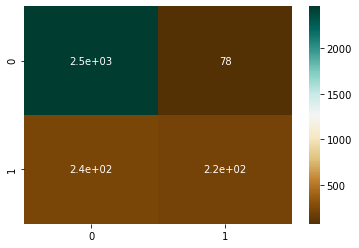

In [14]:
plot_confusion_matrix(rfc, X_test_joined, y_test)

In [15]:
pred = rfc.predict(X_test_joined)

In [16]:
pred_df = X_test.copy()
pred_df['predicted_ad'] = pred
pred_df['actual_ad'] = y_test
pred_df.head()

,start_snip,end_snip,sentence,cluster,ad_cluster,news_cluster,snip_ad,topic_0,topic_1,topic_2,...,has_next_good evening,has_next_welcome,has_prev_after this,has_next_good morning,has_prev_applause,has_next_applause,has_prev_tuned,has_prev_go away,predicted_ad,actual_ad
367,2160,2220,tell me about this.,2,0,0,0,0.013333,0.013333,0.013333,...,0,0,0,0,0,0,0,0,0.0,0.0
5652,5520,5580,that you may recall who made the trip to centr...,2,0,0,0,0.006667,0.006667,0.006667,...,0,0,0,0,0,0,0,0,0.0,0.0
8942,1200,1260,her big effort is coming up next.,2,0,0,0,0.006667,0.006667,0.006667,...,0,1,0,0,0,0,0,0,0.0,0.0
5811,6540,6600,sandra: what a beautiful thing.,2,0,0,0,0.006667,0.006667,0.006667,...,0,0,0,0,0,0,0,0,0.0,0.0
3890,14100,14160,he's heading through to the final wall climb a...,2,0,0,0,0.013333,0.013333,0.013333,...,0,0,0,0,0,0,0,0,0.0,0.0


View sentences thhat are false positives, i.e. falsely identified as ads.

In [17]:
for row in pred_df[(pred_df.predicted_ad == 1) & (pred_df.actual_ad == 0)]['sentence']:
    print(row)

it's no small camper.
 we have allstate.
 there is no jury.
he ran a brewery in denver.
this meter shows how much stuff, or dissolved solids, gets left behind.
my guess is when he goes he will have his own stage.
 it was not an airplane.
   shannon: a police officer in texas is being hailed a hero after rescuing a tiny kitten that got stuck in a vehicle engine.
  yes.
she's the progressive insurance lady.
whether it's a year old or a few years old, we want to buy your car.
you get to be old enough,.
before taking ibrance, tell your doctor if you have fever, chills, or other signs of infection,
there are other incertainties.
they have an estimated 25000 active fighters just along the northern border.
 bill: this alarming scene from venice, italy.
these two need to rewatch "bambi."
across the border whether it be avocados or all auto parts. and beer.
it's the final days to save $1000 on the new queen sleep number 360 special edition smart bed, only $1,799. ends sunday.
 that is a disgrac

View false negatives, i.e. sentences falsely marked as NOT being ads.

In [18]:
for row in pred_df[(pred_df.predicted_ad == 0) & (pred_df.actual_ad == 1)]['sentence']:
    print(row)

over 75 years of savings and service. this ijust listen.
that's why you're my favorite... i know.
or, to laugh out loud.
i love you mom.
 we're going to see how handy you guys are.
man 2: mine was rare.
 i'm real!
hey, that baker lady's on tv again.
uncover the lost chapters of your family history with ancestry.
i go on a trip.
  don't tell your mother. dad, it's fine.
find them with the refrigerated desserts.
do not take neulastaÂ® if you're allergic to it or neupogen (filgrastim).
to craig, this rock.
all with nationwide coverage... tracfone.
of moderate to advanced amd progression.
it's just really chic.
i love the lights.
plus, 0% interest for 48 months on most beds.
i would pull up in this in a heartbeat.
this comes on all trim packages.
don't just dream about your next vacation.
which means a heart attack or stroke.
 there is reward.
 yeah
now we've created a brand new way for you to sell your car.
 simple.
maybe that's why most of our clients come from other money managers. fish

In this section, I run the model on a small additional set of wild data to see how it performs on data not in the training or testing set. See final report for a discussion of the results.

In [19]:
extra_df = pd.read_csv('../data/interim/fox_to_be_tested.csv')

In [20]:
extra_df = extra_df[10001:10301]
len(extra_df)

300

In [21]:
extra_fea = extra_df.drop(columns=['identifier', 'contributor', 'subjects', 'start_time', 'stop_time', 'runtime']).dropna()
extra_bow = vect.transform(extra_fea['sentence'])

In [22]:
extra_bow_df = pd.DataFrame(extra_bow.toarray())
extra_bow_df.columns = vect.get_feature_names()
extra_joined = extra_fea.reset_index().join(extra_bow_df, lsuffix='_l', rsuffix='_r').drop(columns=['index'])

In [23]:
extra_joined = extra_joined.drop(columns=['sentence_l', 'sentence_r'])

In [24]:
extra_joined = extra_joined.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [25]:
extra_joined.head()

,start_snip,end_snip,cluster,ad_cluster,news_cluster,snip_ad,topic_0,topic_1,topic_2,topic_3,...,youve got,youve vaccine,yup,yup thats,zen,zero,zerowater,zerowaters,zerowaters stage,zone
0,5940,6000,2,0,0,0,0.006667,0.006667,0.006667,0.006667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5940,6000,2,0,0,0,0.013333,0.013333,0.013333,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5940,6000,2,0,0,0,0.006667,0.006667,0.006667,0.006667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5940,6000,2,0,0,0,0.006667,0.006667,0.006667,0.006667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5940,6000,2,0,0,0,0.006667,0.006667,0.006667,0.006667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
pred = rfc.predict(extra_joined)

In [27]:
extra_df['pred_ad'] = pred
extra_df.to_csv('../data/processed/fox_wild_test.csv')

In this section, I test the FOX model on CNN sentences, and found it was surprisingly accurate. It will be interesting to see if the opposite is true.

In [28]:
cnn_df = pd.read_excel('../data/interim/cnn_ready_to_code.xlsx').drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).fillna(0)
len(cnn_df)

10000

In [29]:
cnn_df['sentence'] = cnn_df['sentence'].astype('str')

In [30]:
cnn_fea = cnn_df.drop(columns=['identifier', 'contributor', 'subjects', 'start_time', 'stop_time', 'isad',
                                 'runtime'])
cnn_bow = vect.transform(cnn_fea['sentence'])
cnn_bow_df = pd.DataFrame(cnn_bow.toarray())
cnn_bow_df.columns = vect.get_feature_names()
cnn_joined = cnn_fea.reset_index().join(cnn_bow_df, lsuffix='_l', rsuffix='_r').drop(columns=['index'])
cnn_joined = cnn_joined.drop(columns=['sentence_l', 'sentence_r'])

In [31]:
cnn_true = cnn_df['isad']

In [32]:
print("Accuracy of FOX model on CNN: {}".format(rfc.score(cnn_joined, cnn_true)))

Accuracy of FOX model on CNN: 0.7579


[[6903  321]
 [2100  676]]


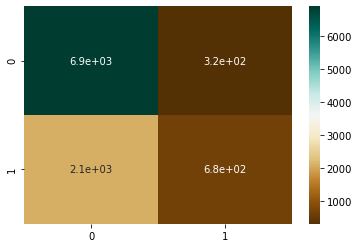

In [33]:
plot_confusion_matrix(rfc, cnn_joined, cnn_true)